# Extract image pathces of target from Database query

This notebook extracts an image patch around the target area. It is based on the query images notebook and uses that as a base for locating the target information.

For this notebook to work, you will require a working ArangoDB. See http://localhost:8888/lab/tree/1_import_bagfiles.ipynb for how to set that up.

It is divided into multiple parts. The first is for looking at he query and allows for tuning in order to get the correct image patch. The later part will go though the bag files individually and extract the target from the images and then sort them according to bagfile origin.

## Set Up

In [11]:
import numpy as np
import quaternion
import cv2
import os

from scripts.query_image import *

# Parameters
ros_topic_pose = "/gnc/ekf".replace("/", "_")[1:]
ros_topic_image = "/hw/cam_sci/info".replace("/", "_")[1:]

Specify the targets location and size:

In [12]:
# Target Pose
target_position = np.array([-0.84, 0.6, -0.81])
target_attitude = quaternion.from_euler_angles(0, 0, np.radians(180))  # order is roll, pitch, yaw

# Query Contraints
max_distance = 1.0
min_distance = 0.2
max_angle = 30

# Target size, the target is pointed to in the x-axis
target_size_y = 0.05
target_size_z = 0.07

Define the image data folder and where you would like the program to save the extracted image patches. The program will group the images by bagfile in the specified directory. They will have a the same name as the source image with patch added to the front:

In [13]:
image_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/'
save_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/'

# Print image and directory information?
print_info = True

## Preview the query

Query the whole database for images that contain the target

In [14]:
result_all = query_image(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z,[])

TypeError: query_image() takes 9 positional arguments but 10 were given

Plot a few of the obtained images with the target highlighted

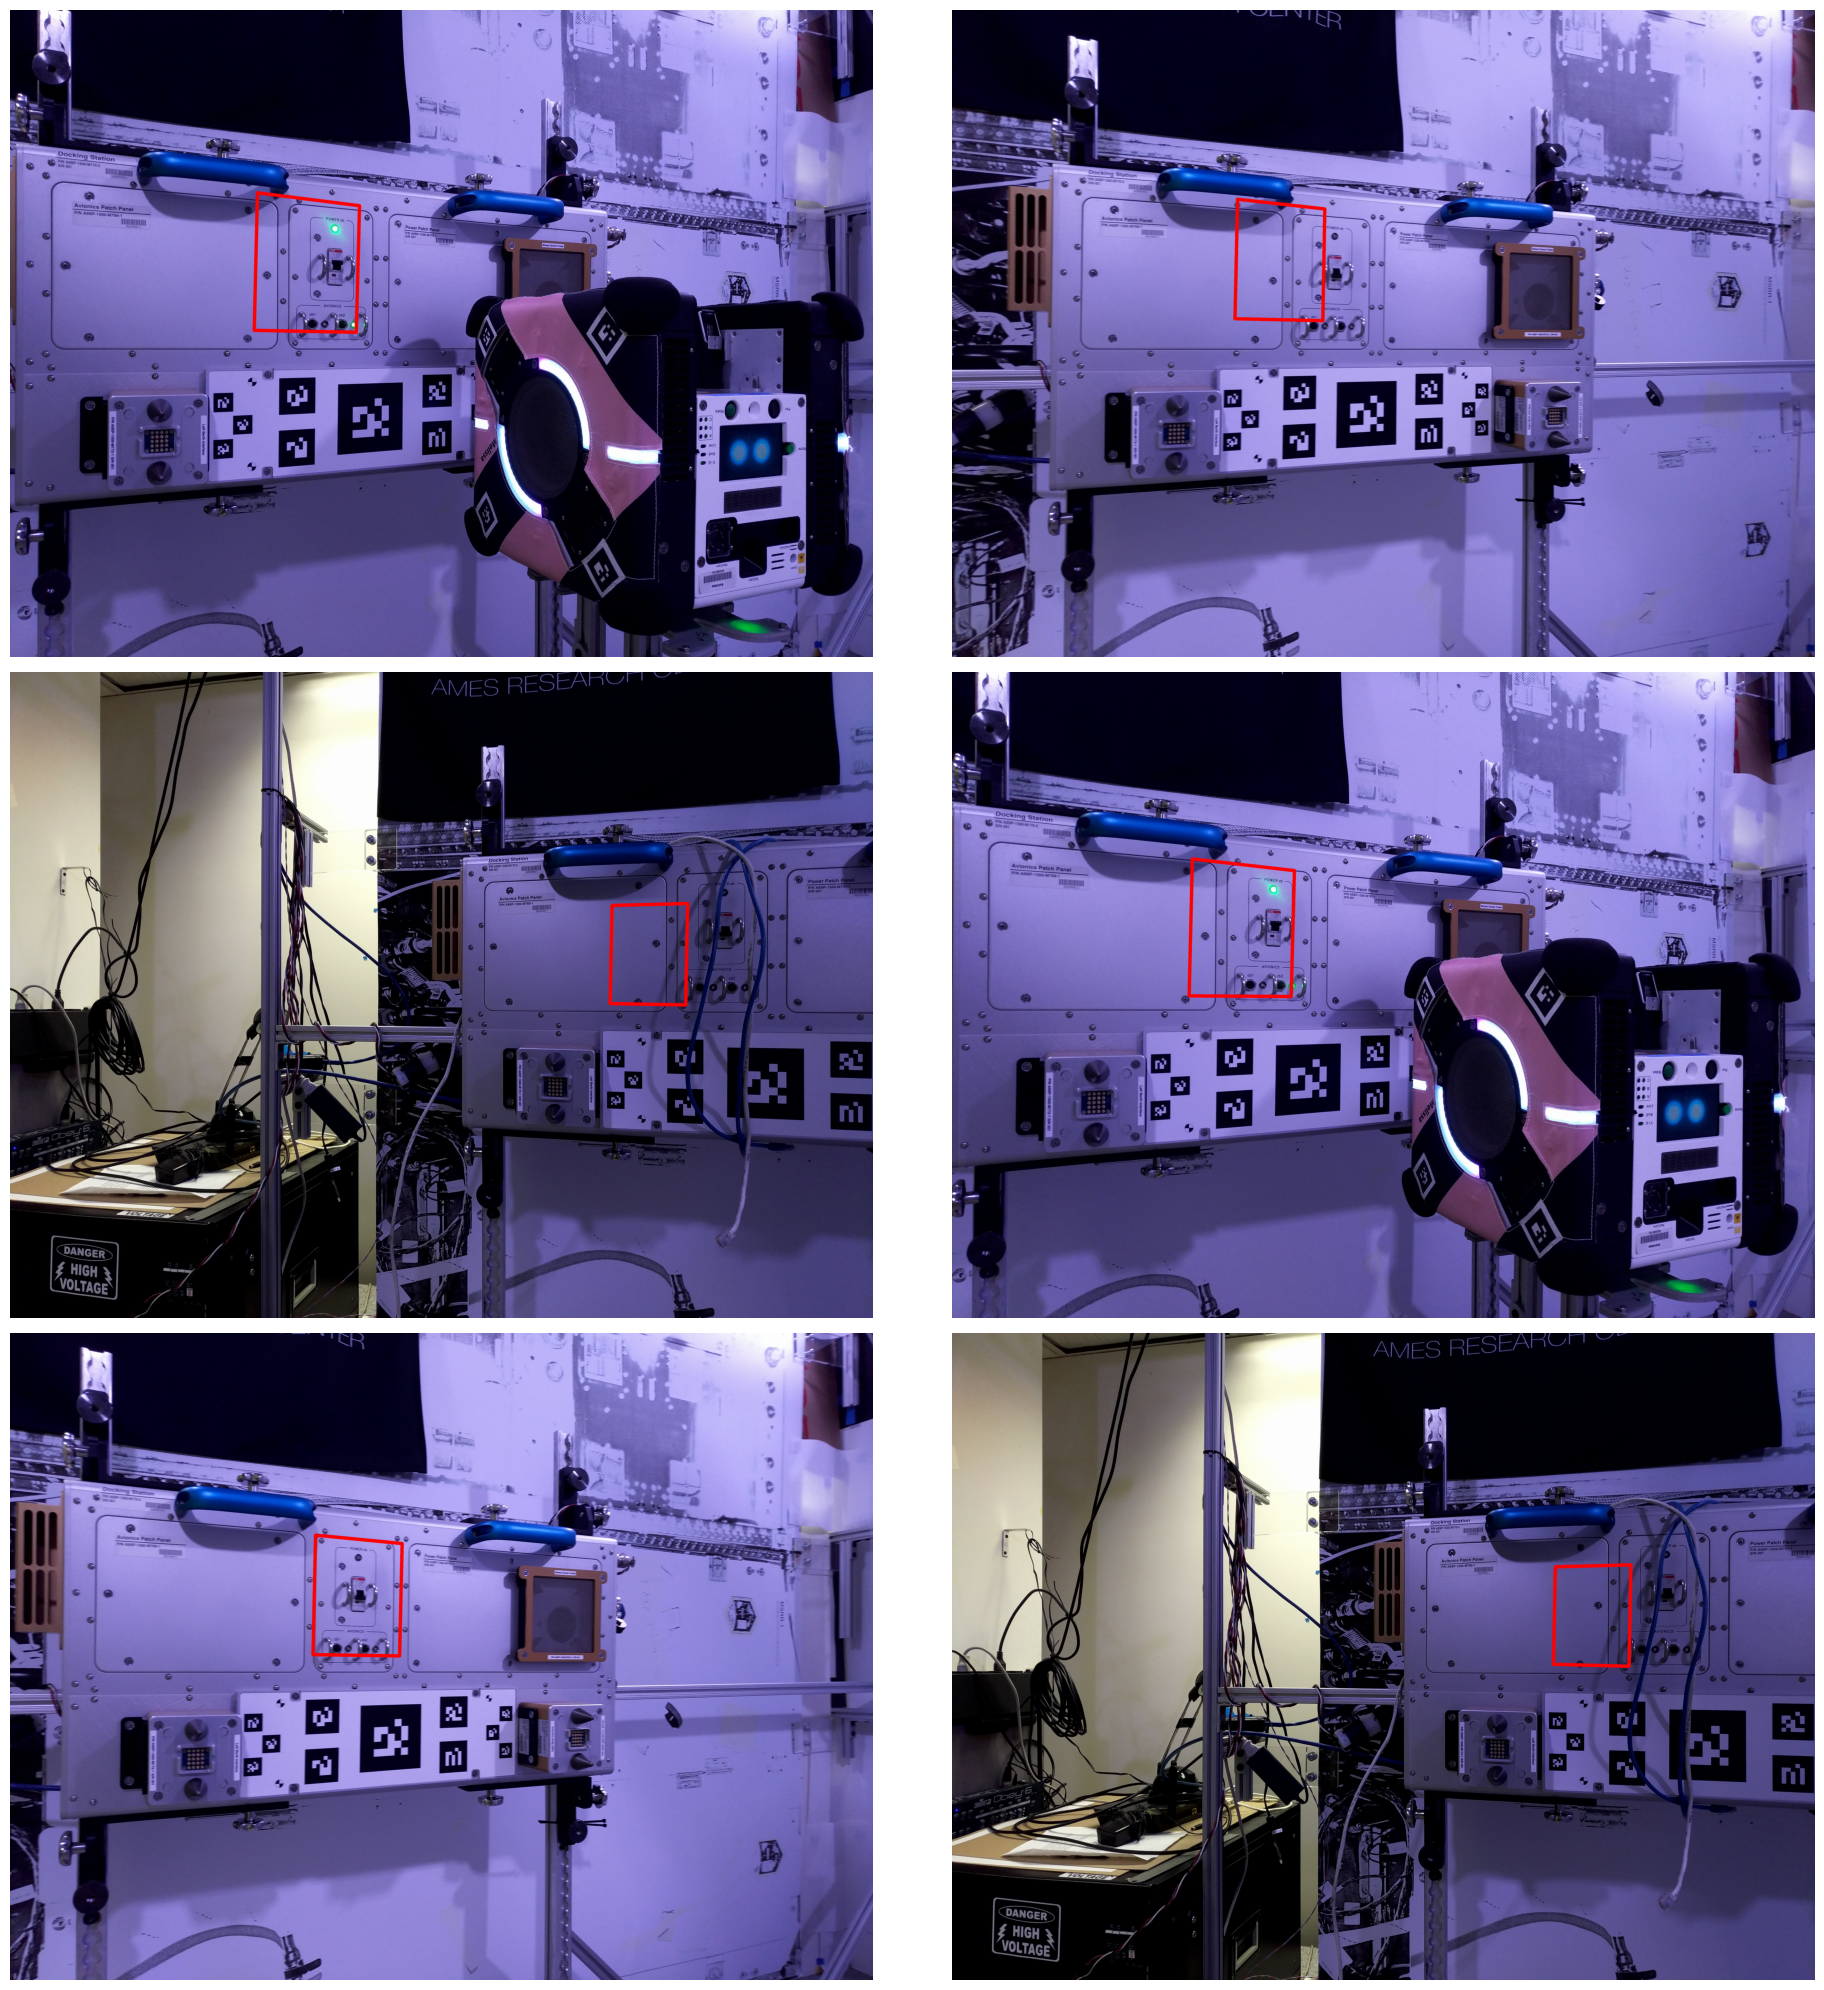

In [7]:
from scripts.plot_query_result import *

max_images = 6
num_columns = 2
fig_size = 20
plot_query_result(result_all, max_images, num_columns, fig_size)


## Extract the image patch around the target area

The extract_images function takes the wanted image and the corners of the patch/taget in the image. It extracts the target and corrects for the perspecitve.

In [8]:
def extract_image(image, corners): #takes the image and the corners in a numpy array as input and returns the image with corrected perspective.
     # Define the perfect square corners
    perfect_square = np.array([[0, 0], [0, 500], [500, 500], [500, 0]], dtype=np.float32)

    # Convert the corner points to numpy array
    corners = np.array(corners, dtype=np.float32)

    # Calculate the perspective transformation matrix
    M = cv2.getPerspectiveTransform(corners, perfect_square)

    # Apply the perspective transformation to the image
    corrected_image = cv2.warpPerspective(image, M, (700, 500))  # Adjust the size as needed

    corrected_image = np.transpose(corrected_image, (1,0,2))

    return corrected_image


The save_images function takes the result from the query of the database, the designated save_path and the bagfile name. It then calls the extract_image function to get the image patches.
Once the patches are extracted the program checks if there is a directory, if not it creates one.
The patches are then saved to the directory.

In [9]:
def save_images(result, save_path, bag):
    for idx, element in enumerate(result):
        image = cv2.imread(image_path + element['img'])
    
        corners = [element['coord_c3'],element['coord_c2'],element['coord_c1'],element['coord_c4']]

        extracted_image = extract_image(image, corners)
        
        save_directory = (save_path + bag + '/')
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
            print('Made directory ' + save_directory)

    
        if print_info == True: print('--Extracted patch from image'+ element['img'] + '" in directory (' + image_path + ') and saved it as ' + 'patch_' + element['img'] + ' in directory (' + save_directory + ')')
        
        #print(i)
        cv2.imwrite(save_directory + 'patch_' + element['img'], extracted_image)

    print('Done extracting and saving image patches\n')

In [10]:
directory_path = 'data/bags/2024-03-21_tim/bsharp/Fixed' # Specify the path to your bagfiles
bags = os.listdir(directory_path)
#print(bags)

for bag in bags:
    bag_path = os.path.join(directory_path, bag)

    if os.path.isfile(bag_path) and bag_path.endswith('.bag'):
        print('Extracting from bag ' + bag)
        result = query_image(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z, bag)
        if result is not None:
            save_images(result, save_path, bag)
        else:
            print('No images found\n')

Extracting from bag 20240321_2238_survey_test_profile_0.fix_all.bag
Connected to isaac database
From database got 0 matches
From first filtering got 0 matches
Query successful, got 0 matches
No images found

Extracting from bag 20240321_2232_survey_test_0.fix_all.bag
Connected to isaac database
From database got 22 matches
From first filtering got 0 matches
Query successful, got 0 matches
No images found

Extracting from bag 20240321_2254_survey_bsharp7_0.fix_all.bag
Connected to isaac database
From database got 192 matches
From first filtering got 86 matches
Query successful, got 86 matches
--Extracted patch from image1711061715.139.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as patch_1711061715.139.jpg in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/20240321_2254_survey_bsharp7_0.fix_all.bag/)
--Extracted patch from image1711061715.139.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_i